In [27]:
import numpy as np
from scipy.special import hermitenorm

def projection_onto_u(z, u):
    '''
    This function calculates the projection of z onto the direction u.
    '''
    # The projection matrix given by u is u outer product with u
    proj = np.outer(u, u)
    # Then we calculate the projection of z reshaped to a matrix
    z = z.reshape(-1, len(u))
    proj_z = proj @ z
    return proj_z

def multivariate_hermite_polynomial_vectorized(X, indices, precomputed_hermites):
    """
    计算在给定矩阵 X 处关于 x 的第 (i, j, k, l) 分量的多元四次Hermite多项式的值。

    参数:
    X : numpy array
        n*d 矩阵，其中每个行向量是一个 d 维向量。
    indices : tuple of int
        四个整数(i, j, k, l)，每一个都是1到d之间的一个整数。
    precomputed_hermites : dict
        预先计算好的Hermite多项式字典，键是 (索引, 次数)，值是多项式函数。

    返回:
    numpy array
        多元Hermite多项式在 X 处的值，形状为 (n,)。
    """
    unique_indices, counts = np.unique(indices, return_counts=True)

    # 初始化结果为1的向量
    result = np.ones(X.shape[0])
    
    # 计算每个独立索引的Hermite多项式
    for idx, count in zip(unique_indices, counts):
        H = precomputed_hermites[(idx, count)]
        result *= H(X[:, idx - 1])
    
    return result

d = 10
n = d**4+1
# X是一个n*d矩阵，每一个行向量是一个d维向量，是标准正态分布
X = np.random.randn(n, d)
#从R^{d^2}中的单位球面上任取一个方向向量u
u = np.random.randn(d*d)
u = u / np.linalg.norm(u)

# 初始化所有可能的索引 (i, j, k, l)
all_indices = [(i, j, k, l) for i in range(1, d + 1) for j in range(1, d + 1) for k in range(1, d + 1) for l in range(1, d + 1)]

# 预计算所有需要的Hermite多项式
precomputed_hermites = {}
max_order = max([4])  # 这里的4是固定的次数，可以根据实际需要调整
for idx in range(1, d + 1):
    for order in range(1, max_order + 1):
        # 使用归一化的Probabistic Hermite多项式
        precomputed_hermites[(idx, order)] = hermitenorm(order)/ np.sqrt(np.math.factorial(order))
# 计算所有Hermite多项式值
hermite_values = np.array([multivariate_hermite_polynomial_vectorized(X, idx, precomputed_hermites) for idx in all_indices]).reshape(d, d, d*d, n)

# 计算点积
dot_products = np.tensordot(hermite_values, u, axes=([2], [0]))

# 计算点积的平方和
sum_of_squares = np.sum(np.square(dot_products))

# 计算所有平方和求和除以n^2
result = np.sqrt(sum_of_squares) / n
print(result)
# print(precomputed_hermites[(6,1)])

/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_61855/4143032522.py:60: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  precomputed_hermites[(idx, order)] = hermitenorm(order)/ np.sqrt(np.math.factorial(order))


0.0961261661227478


/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_61855/2091789073.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  precomputed_hermites[(idx, order)] = hermitenorm(order) / np.sqrt(np.math.factorial(order))


Shape of Z: (10001, 10000)
First column of Z: [-1.22218979  0.58704863  1.3012127 ], , Normalized 4 order Hermite polynomial: [-1.22218979  0.58704863  1.3012127 ]


/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_61855/2091789073.py:30: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  print(f'First column of Z: {Z[0:3, 0]}, , Normalized 4 order Hermite polynomial: {hermitenorm(4)(X[0:3, 0])/ np.sqrt(np.math.factorial(4))}')


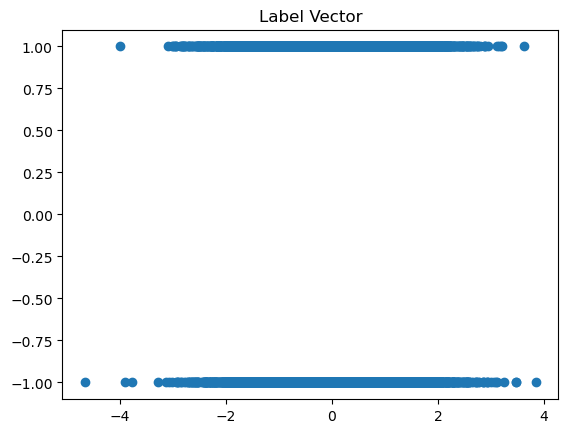

In [28]:

# The realistic oprimization problem part
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import hermitenorm

n = d**4+1
np.random.seed(0)
X = np.random.randn(n, d)

precomputed_hermites = {}
max_order = max([4])
for idx in range(1, d + 1):
    for order in range(1, max_order + 1):
        precomputed_hermites[(idx, order)] = hermitenorm(order) / np.sqrt(np.math.factorial(order))

def hermite_feature_vector(X):
    n, d = X.shape
    all_indices = [(i, j, k, l) for i in range(1, d + 1) for j in range(1, d + 1) for k in range(1, d + 1) for l in range(1, d + 1)]
    hermite_values = np.array([multivariate_hermite_polynomial_vectorized(X, idx, precomputed_hermites) for idx in all_indices]).reshape(d*d*d*d,n)
    # return the hermite values transposed
    return hermite_values.T

# Generate features
Z = hermite_feature_vector(X)
p = Z.shape[1]

# Sanity check
print(f'Shape of Z: {Z.shape}')
print(f'First column of Z: {Z[0:3, 0]}, , Normalized 4 order Hermite polynomial: {hermitenorm(4)(X[0:3, 0])/ np.sqrt(np.math.factorial(4))}')

# First we generate the signals
def signal(X):
    n, d = X.shape
    theta_star = np.zeros(d)
    theta_star[0] = 1
    # Independent copy of X
    X_prime = np.random.randn(n, d)
    Y = np.sign(X_prime.dot(theta_star)- hermitenorm(5)(X_prime @ theta_star))
    return Y

# Parameters 
theta_star = np.zeros(d)
theta_star[0] = 1
Y = signal(X)

# Plot
plt.scatter(X[:, 0], Y)
plt.title('Label Vector')
plt.show()

Optimal weights: [-0.00184655  0.00047324  0.00630797 ...  0.00338085  0.00032823
  0.00780745]


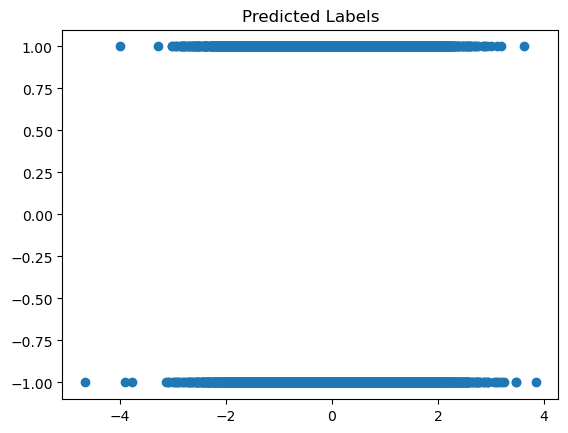

In [29]:
from scipy.optimize import minimize
# u = np.random.randn(d*d)
# u = u / np.linalg.norm(u)
# # 给u补零扩充到d^4维度
# u = np.concatenate((u,np.zeros(p-d*d)))
w = np.zeros(p)
lambda_ = 0.1

# Let us do logistic regression conditional on the weights contracts with u is 0, \sum_{i=1}^{d*d} u_i w_{i} = 0.
# 定义逻辑回归的损失函数和梯度
def logistic_loss(w, Z, Y):
    n, p = Z.shape
    obj = 0
    for i in range(n):
        obj += np.log(1 + np.exp(-Y[i]*w @ Z[i]))
    obj = obj/n + lambda_ * np.linalg.norm(w)**2
    return obj

def logistic_loss_grad(w, Z, Y):
    n, p = Z.shape
    grad = np.zeros(p)
    for i in range(n):
        grad += -Y[i]*Z[i]/(1 + np.exp(Y[i]*w @ Z[i]))
    grad = grad/n + 2*lambda_*w
    return grad

# 定义约束条件
# cons = {'type': 'eq', 'fun': lambda w: w.reshape(d*d, d*d) @ u}

# 优化
res = minimize(logistic_loss, w, args=(Z, Y), jac=logistic_loss_grad, method='SLSQP')

# 输出结果
w_opt = res.x
# 我们从R^{d^4}中的单位球面上任取一个方向向量w_opt
# w_opt = np.random.randn(p)
# w_opt = w_opt / np.linalg.norm(w_opt)
print("Optimal weights:", w_opt)

# 预测
Y_pred = np.sign(Z.dot(w_opt))

# 绘制预测结果
plt.scatter(X[:, 0], Y_pred)
plt.title('Predicted Labels')
plt.show()
# print("Optimal loss:", logistic_loss(w_opt, Z, Y))

In [30]:
# def projection_onto_u(z, u):
#     '''
#     This function calculates the projection of z onto the direction u.
#     '''
#     # The projection matrix given by u is u outer product with u
#     proj = np.outer(u, u)
#     # Then we calculate the projection of z reshaped to a matrix
#     z = z.reshape(-1, len(u))
#     proj_z = proj @ z
#     return proj_z

# def Concentration_objective(w, Z, Y):
#     n, p = Z.shape
#     grad = np.zeros(p).reshape(-1, d*d)
#     for i in range(n):
#         # print(f"shapes of Z[i], Y[i], u, projection_onto_u(Z[i],u): {Z[i].shape, Y[i].shape, u.shape, projection_onto_u(Z[i],u).shape, (1 + np.exp(Y[i]*w @ Z[i])).shape}")
#         grad += -Y[i]*projection_onto_u(Z[i],u)/(1 + np.exp(Y[i]*w @ Z[i]))
#     grad = grad/n 
#     return grad

# Calculate the 2, 2 norm of the minimizer
def Frobenius_norm_concentration_objective(w):
    # First we write w as a matrix
    w = w.reshape(-1, d*d)
    # print(w.shape)
    # Return the operator norm of the matrix
    return np.linalg.norm(w, ord=2)

print("Frobenius norm of the Concentration_objective:", Frobenius_norm_concentration_objective(w_opt))

Frobenius norm of the Concentration_objective: 0.05672609393087488


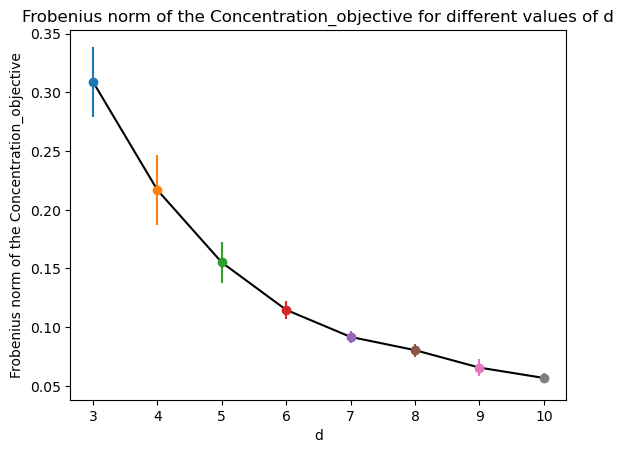

In [31]:
# For different values of d, we do the same thing and plot the Frobenius norm of the Concentration_objective
# Foe each value d, we repeat several times, and draw the value with standard deviation
d_values = [3, 4, 5, 6, 7, 8, 9, 10]
frobenius_norm_values = dict()
for d in d_values:
    # w = np.zeros(p)
    # lambda_ = 0.1
    
    # cons = {'type': 'eq', 'fun': lambda w: w.reshape(d*d, d*d) @ u}
    # res = minimize(logistic_loss, w, args=(Z, Y), jac=logistic_loss_grad, constraints=cons, method='SLSQP')
    for _ in range(10):
        n = d**4+1
        X = np.random.randn(n, d)
        Z = hermite_feature_vector(X)
        p = Z.shape[1]
        theta_star = np.zeros(d)
        theta_star[0] = 1
        Y = signal(X)
        w = np.zeros(p)
        res = minimize(logistic_loss, w, args=(Z, Y), jac=logistic_loss_grad, method='SLSQP')
        w_opt = res.x
        # We calculate the Frobenius norm of the Concentration_objective and store it in the dictionary
        frobenius_norm = Frobenius_norm_concentration_objective(w_opt)
        if d in frobenius_norm_values:
            frobenius_norm_values[d].append(frobenius_norm)
        else:
            frobenius_norm_values[d] = [frobenius_norm]

# Plot the results
plt.figure()
for d in d_values:
    plt.errorbar(d, np.mean(frobenius_norm_values[d]), yerr=np.std(frobenius_norm_values[d]), fmt='o')
    # Draw line segment to connect each mean value
    if d > 3:
        plt.plot([d-1, d], [np.mean(frobenius_norm_values[d-1]), np.mean(frobenius_norm_values[d])], 'k-')

plt.xlabel('d')
plt.ylabel('Frobenius norm of the Concentration_objective')
plt.title('Frobenius norm of the Concentration_objective for different values of d')
plt.show()

In [22]:
d_values = [3, 4, 5, 6]
ratio_values = d_values/np.power(d_values, 4)
print(ratio_values)

[0.03703704 0.015625   0.008      0.00462963]
